# Multi-TS Forecast

In [32]:
import os
os.chdir(os.environ['PWD'])

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
from app.conf import model_utils as muts
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import json

#### Import Historical Data

In [34]:
dataset_filtered = uts.load_artifact('prices_dataframe', sts.LOCAL_ARTIFACTS_PATH)

In [35]:
dataset_filtered.head()

,date,group,product,market,mean_price
0,2013-01-01,carnes,alas de pollo con costillar,armenia mercar,NaN
1,2013-02-01,carnes,alas de pollo con costillar,armenia mercar,NaN
2,2013-03-01,carnes,alas de pollo con costillar,armenia mercar,NaN
3,2013-04-01,carnes,alas de pollo con costillar,armenia mercar,NaN
4,2013-05-01,carnes,alas de pollo con costillar,armenia mercar,NaN


In [36]:
dataset_filtered['date'] = pd.to_datetime(dataset_filtered['date'])

## Time Series Forecasting

In [37]:
date_range = pd.date_range(
    start = dataset_filtered['date'].min(), 
    end = dataset_filtered['date'].max(), 
    freq = 'MS'
)

In [38]:
n_series = dataset_filtered.shape[0] // date_range.shape[0]

In [39]:
dataset_filtered['group'].nunique(), dataset_filtered['product'].nunique(), dataset_filtered['market'].nunique()

(8, 319, 72)

In [40]:
dataset_filtered['series_id'] = dataset_filtered.groupby(['group', 'product', 'market']).ngroup()

In [41]:
get_date_range = lambda start: pd.date_range(start = start, end = dataset_filtered['date'].max(), freq = 'MS')

In [42]:
multi_X_2 = []
multi_X_fore_2 = []
multi_y_2 = []
series_id_series = []

multi_y_pred_1 = []

In [43]:
predictions = {}

In [44]:
for series_id, series_df in tqdm(dataset_filtered.groupby('series_id')):
    series_df.set_index('date', inplace=True)
    group = series_df['group'].unique()[0]
    y = series_df['mean_price'].astype(float)
    date_range_idx = get_date_range(y.first_valid_index())
    y = y.reindex(date_range_idx).interpolate('linear')
    
    X_1, X_fore_1 = muts.get_X_det(y, forecast_steps = 1)
    model_1, y_pred_1, residuals = muts.get_model(y, X_1, LinearRegression(), return_residuals = True)
    
    pred = {
        'index':X_fore_1.index[0],
        'point_det':model_1.predict(X_fore_1)[0]
    }
    predictions[series_id] = pred
    
    y_2, X_fore_2, X_2 = muts.get_X_res(residuals, 3)
    X_2['group'] = group
    X_fore_2['group'] = group
    
    y_pred_frame_1 = y_pred_1.iloc[3:].to_frame()
    y_pred_frame_1['series_id'] = series_id
    y_pred_frame_1['y_true'] = y.iloc[3:]
    
    multi_y_pred_1.append(y_pred_frame_1)
    multi_X_2.append(X_2)
    multi_X_fore_2.append(X_fore_2)
    multi_y_2.append(y_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3412/3412 [00:31<00:00, 107.61it/s]


In [24]:
y = y.reindex(date_range_idx)

In [30]:
y.astype(float).interpolate().isna().sum()

0

In [14]:
multi_X_2 = pd.concat(multi_X_2)
multi_X_fore_2 = pd.concat(multi_X_fore_2)
multi_y_2 = pd.concat(multi_y_2)

multi_y_pred_1 = pd.concat(multi_y_pred_1)

In [15]:
forecast_date = X_fore_1.index[0].strftime('%Y-%m')

In [16]:
predictions[0]

{'index': Timestamp('2022-12-01 00:00:00', freq='MS'),
 'point_det': 11930.812924899705}

In [17]:
feature_pipeline = ColumnTransformer(
    transformers=[
        ('group_onehot', OneHotEncoder(handle_unknown='ignore'), ['group']),
        ('numeric', 'passthrough', ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_rolling_std'])
    ],
)

In [18]:
feature_pipeline.fit(multi_X_2)

ColumnTransformer(transformers=[('group_onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['group']),
                                ('numeric', 'passthrough',
                                 ['y_lag_1', 'y_lag_2', 'y_lag_3',
                                  'y_rolling_std'])])

In [19]:
trans_multi_X_2 = feature_pipeline.transform(multi_X_2)

In [20]:
model_2, multi_y_pred_2 = muts.get_model(multi_y_2, trans_multi_X_2, KNeighborsRegressor(), return_residuals=False)

In [21]:
multi_y_pred_1.shape

(373987, 3)

In [22]:
multi_y_pred_2.shape

(373987,)

In [23]:
multi_y_pred_1['y_pred'] = multi_y_pred_2 + multi_y_pred_1[0]

In [24]:
multi_y_pred_1['residuals'] = multi_y_pred_1['y_true'] - multi_y_pred_1['y_pred']

In [25]:
std_preds = multi_y_pred_1.groupby(['series_id'])['residuals'].std().to_dict()

In [26]:
point_res = pd.Series(model_2.predict(feature_pipeline.transform(multi_X_fore_2)), index = np.arange(multi_X_fore_2.shape[0])).to_dict()

In [27]:
final_predictions = {
    series_id:{
        'point_res': point_res[series_id],
        **predictions[series_id],
        'std': std_preds[series_id],
        'point': predictions[series_id]['point_det'] + point_res[series_id],
        'lower': predictions[series_id]['point_det'] + point_res[series_id] - std_preds[series_id],
        'upper': predictions[series_id]['point_det'] + point_res[series_id] + std_preds[series_id]
    }
    for series_id in np.arange(n_series)
}

In [28]:
series_id = 549

In [29]:
final_predictions[series_id]

{'point_res': 746.0828657364347,
 'index': Timestamp('2022-12-01 00:00:00', freq='MS'),
 'point_det': 6785.104722462632,
 'std': 241.06553663115437,
 'point': 7531.187588199066,
 'lower': 7290.122051567912,
 'upper': 7772.25312483022}

In [30]:
series_df = dataset_filtered[dataset_filtered.series_id==series_id]
series_df.set_index('date', inplace=True)
group = series_df['group'].unique()[0]
y = series_df['mean_price']
date_range_idx = get_date_range(y.first_valid_index())
y = y.reindex(date_range_idx).interpolate()

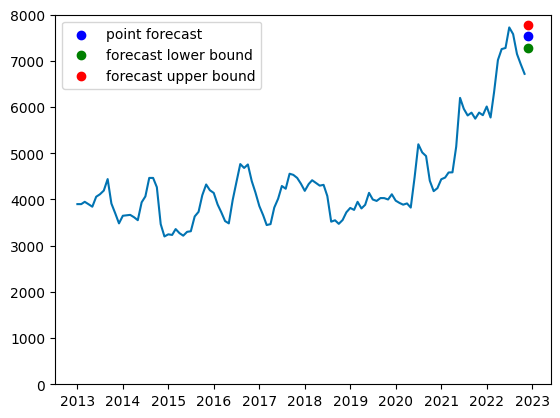

In [31]:
plt.plot(y)
plt.scatter(x = final_predictions[series_id]['index'], y = final_predictions[series_id]['point'], color = 'b', label = 'point forecast')
plt.scatter(x = final_predictions[series_id]['index'], y = final_predictions[series_id]['lower'], color = 'g', label = 'forecast lower bound')
plt.scatter(x = final_predictions[series_id]['index'], y = final_predictions[series_id]['upper'], color = 'r', label = 'forecast upper bound')
plt.legend()
plt.ylim(bottom=0)
plt.show()

#### Build routing dicts: 
1. series_to_id_dict: tuple(product, market) -> series_id
2. id_to_market_dict: series_id -> market
3. product_to_series_dict: product -> list(series_ids) product in different markets

In [32]:
series_to_id_dict = dataset_filtered[['product', 'market', 'series_id']].drop_duplicates().set_index(['product', 'market']).squeeze().to_dict()

In [33]:
len(series_to_id_dict)

3412

In [34]:
id_to_market_dict = {v:k[1] for k,v in series_to_id_dict.items()}

In [35]:
len(id_to_market_dict)

3412

In [36]:
product_to_series_dict = dataset_filtered[['product', 'series_id']].drop_duplicates().groupby(['product'])['series_id'].apply(lambda x: list(np.unique(x))).to_dict()

In [37]:
len(product_to_series_dict)

319

#### Multiple series for one product query

In [38]:
product = 'maracuya'

In [39]:
series_for_product = product_to_series_dict.get(product, [])

In [40]:
predictions = {}

In [41]:
for series_id in series_for_product:
    market = id_to_market_dict[series_id]
    predictions[market] = {
        'point': final_predictions[series_id]['point'],
        'lower': final_predictions[series_id]['lower'],
        'upper': final_predictions[series_id]['upper']
    }

In [42]:
predictions

{'arauca arauca': {'point': 3840.819580318331,
  'lower': 3558.316239004425,
  'upper': 4123.322921632237},
 'armenia mercar': {'point': 2984.1795810787207,
  'lower': 2628.677627723331,
  'upper': 3339.6815344341103},
 'bogota dc corabastos': {'point': 3478.192479016612,
  'lower': 2838.237805999047,
  'upper': 4118.147152034177},
 'bucaramanga centroabastos': {'point': 2953.8268285818085,
  'lower': 2547.3773874169274,
  'upper': 3360.2762697466896},
 'buenaventura valle del cauca': {'point': 4083.5405386689445,
  'lower': 3709.343227530293,
  'upper': 4457.737849807596},
 'cali cavasa': {'point': 2923.451723413738,
  'lower': 2524.9394716489824,
  'upper': 3321.9639751784935},
 'cartago valle del cauca': {'point': 3581.919868530027,
  'lower': 3207.8938890413297,
  'upper': 3955.9458480187245},
 'chiquinquira boyaca': {'point': 2865.082144286039,
  'lower': 2283.7148617156636,
  'upper': 3446.449426856414},
 'cucuta cenabastos': {'point': 4306.4809272331795,
  'lower': 3951.71836183

#### One series for one product-market query

In [43]:
product = 'maracuya'
market = 'bogota dc corabastos'

In [44]:
series_for_product_market = series_to_id_dict.get((product, market), -1)

In [45]:
series_for_product_market

1028

In [46]:
prediction = {
    'point': final_predictions[series_for_product_market]['point'],
    'lower': final_predictions[series_for_product_market]['lower'],
    'upper': final_predictions[series_for_product_market]['upper']
}

In [47]:
prediction

{'point': 3478.192479016612,
 'lower': 2838.237805999047,
 'upper': 4118.147152034177}

### Save Model object with predictions and dicts as artifact

In [48]:
routing_dicts = {
    'series_to_id_dict': series_to_id_dict,
    'id_to_market_dict': id_to_market_dict,
    'product_to_series_dict': product_to_series_dict
}

In [49]:
from app.conf.mymodel import MyModel

In [50]:
model = MyModel(final_predictions, routing_dicts, forecast_date)

In [51]:
model.predict_product('maracuya')

{'arauca arauca': {'point': 3840.819580318331,
  'lower': 3558.316239004425,
  'upper': 4123.322921632237},
 'armenia mercar': {'point': 2984.1795810787207,
  'lower': 2628.677627723331,
  'upper': 3339.6815344341103},
 'bogota dc corabastos': {'point': 3478.192479016612,
  'lower': 2838.237805999047,
  'upper': 4118.147152034177},
 'bucaramanga centroabastos': {'point': 2953.8268285818085,
  'lower': 2547.3773874169274,
  'upper': 3360.2762697466896},
 'buenaventura valle del cauca': {'point': 4083.5405386689445,
  'lower': 3709.343227530293,
  'upper': 4457.737849807596},
 'cali cavasa': {'point': 2923.451723413738,
  'lower': 2524.9394716489824,
  'upper': 3321.9639751784935},
 'cartago valle del cauca': {'point': 3581.919868530027,
  'lower': 3207.8938890413297,
  'upper': 3955.9458480187245},
 'chiquinquira boyaca': {'point': 2865.082144286039,
  'lower': 2283.7148617156636,
  'upper': 3446.449426856414},
 'cucuta cenabastos': {'point': 4306.4809272331795,
  'lower': 3951.71836183

In [52]:
model.predict_product_market('maracuya','medellin plaza minorista jose maria villa')

{'point': 2241.5709857896686,
 'lower': 1957.2531550719746,
 'upper': 2525.8888165073627}

In [53]:
model.get_model_info()

{'model_name': 'Next-Month Colombian Fruit and Veg Prices Predictor',
 'model_version': '1',
 'forecast_date': '2022-12'}

In [54]:
uts.dump_artifact(model, 'model', sts.LOCAL_ARTIFACTS_PATH)